# Rossman dataset 

Fuente xgboost: https://xgboost.readthedocs.io/en/release_3.0.0/

https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.ensemble.XGBRegressor

Correr esto:

!pip install xgboost==1.7.6 scikit-learn==1.2.2

https://www.kaggle.com/competitions/rossmann-store-sales/data

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 8.4 MB/s eta 0:00:18
   - -------------------------------------- 5.0/150.0 MB 13.1 MB/s eta 0:00:12
   -- ------------------------------------- 7.9/150.0 MB 13.2 MB/s eta 0:00:11
   -- ------------------------------------- 10.7/150.0 MB 13.2 MB/s eta 0:00:11
   --- ------------------------------------ 13.6/150.0 MB 13.2 MB/s eta 0:00:11
   ---- ----------------------------------- 16.3/150.0 MB 13.3 MB/s eta 0:00:11
   ----- ---------------------------------- 19.1/150.0 MB 13.1 MB/s eta 0:00:10
   ----- ---------------------------------- 22.0/150.0 MB 13.4 MB/s eta 0:00:10
   ------ --------------------------------- 24.6/150.0 MB 13.0 MB/s eta 0:00:10
   ------- -------------------------------- 27.8/150.0 MB 13.1 MB/s eta 0:00:10
   -------- ------------------------------- 30.4/150.0 MB 13.0 MB/s eta 0:00:10
   -------- ------------------------------- 33.3/150

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Carga de datos
train = pd.read_csv('rossman.csv')
stores = pd.read_csv('store.csv')

# Merge de ambos datasets
df = pd.merge(train, stores, on='Store')

# Convertir la columna de fecha
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha para evitar leakage
df.sort_values('Date')

# Filtrar solo tiendas abiertas
df = df.query("Open == 1")

# Variables temporales útiles, mes y dia del mes
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)
df['month'] = df['Date'].dt.month
df['day_of_month'] = df['Date'].dt.day

# Eliminar columnas que no usaremos
df = df.drop(['Date', 'Customers', 'Open', 'Store'], axis = 1)
df

C:\Users\arant\AppData\Local\Temp\ipykernel_2348\154940743.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('rossman.csv')


,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week_of_year,month,day_of_month
0,5,5263,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,31
1,5,6064,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,31
2,5,8314,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,31
3,5,13995,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,31
4,5,4822,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,2,3375,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,1,1,1
1016827,2,10765,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,1,1,1
1016863,2,5035,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",1,1,1
1017042,2,4491,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,1,1,1


In [7]:
train_threshold = int(len(df) * 0.9)

In [8]:
# split 90% de datos
train_df = df[:train_threshold]
test_df = df[train_threshold:]

# Obten X_train, y_train, X_test, y_test

target = 'Sales'
X_train = train_df.drop(target, axis = 1)
X_test = test_df.drop(target, axis = 1)

y_train = train_df[target]
y_test = test_df[target]

# Codificar variables categóricas (después del split para evitar leakage)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first = True)

# Alinear columnas en test con train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [12]:
# Xgboost

model = XGBRegressor(n_estimators = 100, max_depth = 3, tree_method = 'hist')

# Fit
model.fit(X_train, y_train)

# Predicción y evaluación
predicciones = model.predict(X_test)

r2_score(y_pred = predicciones, y_true = y_test)

0.5119321346282959

In [15]:
# Crea una regresion lineal para ver que tan bien da
from sklearn.linear_model import LinearRegression

# Calcular medias solo en train
means = X_train.mean()

# Aplicar a ambos
X_train = X_train.fillna(means)
X_test = X_test.fillna(means)

# Entrenar modelo
lin_reg = LinearRegression().fit(X_train, y_train)

# Predecir
predicciones = lin_reg.predict(X_test)

# Evaluar
r2_score(y_pred=predicciones, y_true = y_test)

0.18938973781409119

### Tuneando xgboost

- n_estimators: número total de árboles a entrenar. Si usas early_stopping_rounds, puedes poner un número alto sin preocuparte por overfitting.

- max_depth: profundidad máxima de cada árbol. Profundidades mayores capturan más complejidad, pero pueden sobreajustar.

- learning_rate: qué tan rápido aprende el modelo. Valores más bajos requieren más árboles (n_estimators más alto), pero suelen generalizar mejor.

- tree_method: método para construir árboles:

    'exact': busca el mejor split evaluando todos los valores.
    
    'hist': agrupa en bins (default moderno), mucho más rápido.
    
    'gpu_hist': como 'hist' pero usando GPU (⚡ si tienes una buena GPU).

- subsample: fracción de los datos usados en cada árbol (filas). Ayuda a reducir overfitting. Ej: 0.8 usa el 80% de los datos en cada iteración.

- colsample_bytree (¡ojo con el nombre!): fracción de columnas seleccionadas aleatoriamente para cada árbol. También ayuda contra el overfitting.

- early_stopping_rounds: si la métrica en el conjunto de validación no mejora durante N iteraciones, se detiene el entrenamiento (requiere eval_set).

- eval_metric: métrica usada para evaluar el desempeño durante entrenamiento (ej. 'rmse', 'mae', 'logloss', 'auc'). Es la que define si se activa early_stopping.

- gamma: mínima ganancia necesaria para hacer un split adicional. Ayuda a regular complejidad.

- reg_lambda: regularización L2 (Ridge). Útil para evitar sobreajuste.

- reg_alpha: regularización L1 (Lasso). Puede hacer pruning de features.



In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Crea el modelo

model = XGBRegressor(
    n_estimators = 10000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 20
)

# Haz fit, usa early stopping, verboso y evalset [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)



[0]	validation_0-rmse:3030.62666	validation_1-rmse:2986.44196


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:22:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:1997.35625	validation_1-rmse:2082.26481
[200]	validation_0-rmse:1684.36708	validation_1-rmse:1797.20234
[300]	validation_0-rmse:1475.41692	validation_1-rmse:1619.00386
[400]	validation_0-rmse:1337.33295	validation_1-rmse:1510.58306
[500]	validation_0-rmse:1243.43346	validation_1-rmse:1437.34432
[600]	validation_0-rmse:1176.13100	validation_1-rmse:1394.04604
[700]	validation_0-rmse:1128.21151	validation_1-rmse:1369.54782
[800]	validation_0-rmse:1090.31271	validation_1-rmse:1354.55393
[836]	validation_0-rmse:1079.06248	validation_1-rmse:1350.87699


XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, device=None,
             early_stopping_rounds=20, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None, ...)

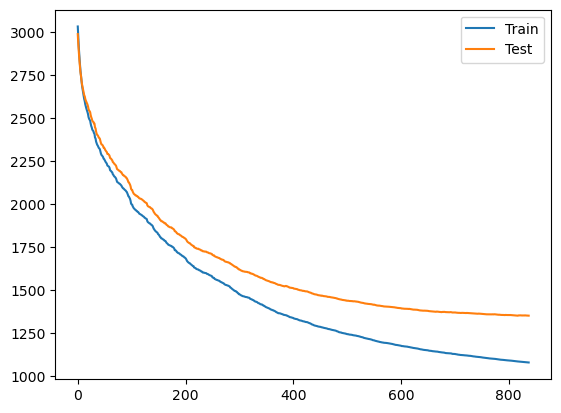

In [20]:
# Extraer resultados

eval_model =  model.evals_result()
train_loss = eval_model['validation_0']['rmse']
test_loss = eval_model['validation_1']['rmse']

plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.legend()
plt.show()


In [4]:
# Grafica ambos errores 


In [7]:
# Calibracion

### Feature importances 

In [21]:
importancias = model.feature_importances_

df_importancias = pd.DataFrame({
    'features': X_test.keys(),
    'importancias': importancias
})

df_importancias.sort_values('importancias', ascending=False)

,features,importancias
16,StoreType_b,0.157554
1,Promo,0.137430
6,Promo2,0.079442
20,Assortment_c,0.068361
22,"PromoInterval_Mar,Jun,Sept,Dec",0.063965
8,Promo2SinceYear,0.060729
4,CompetitionOpenSinceMonth,0.048890
17,StoreType_c,0.047558
3,CompetitionDistance,0.047297
7,Promo2SinceWeek,0.042052


```
from sklearn.inspection import PartialDependenceDisplay

for feature in importancias.features:
    PartialDependenceDisplay.from_estimator(model, X_test, [feature])
    plt.show()
```

In [5]:
# Partial dependence plot 


# Feature importance

### Gain 
Gain es que tanto disminuye la función de perdida, en promedio al usar cada feature


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

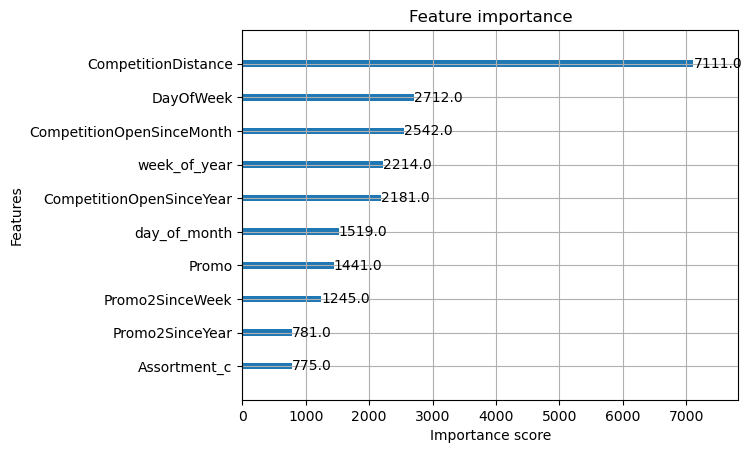

In [ ]:
from xgboost import plot_importance

# Grafica la importancia, por importance_type y el max_num_features
plot_importance(model, max_num_features=10, importance_type="weight") # las veces que se usa

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

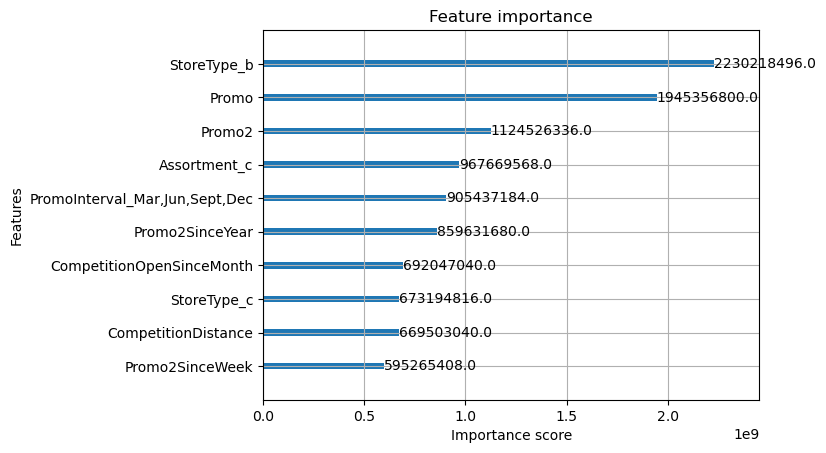

In [ ]:
plot_importance(model, max_num_features=10, importance_type="gain") # la del arbol, cuanto baja la funcion de perdida cada que usas este feature

### Weight
Weighr es el porcentaje de veces que se uso esa variable